## Example 04 - Fuel use
It starts with importing the required libraries, that is done by the next cel. After that, all example-specific relations and objects are defined.

[**Work method:**](#Define-work-method) <br>
Move sand from the *from_site* to the *to_site*. <br>
Use one trailing suction hopper dredger to move the material. <br>
Project is finished if the *from_site* is depleted and the *to_site* is full.

[**Sites:**](#Define-the-project-sites)  <br>
One dredging site. <br>
One placement site.

[**Equipment:**](#Define-the-project-equipment) <br>
One trailing suction hopper dredger.

[**Activities:**](#Define-the-activity)  <br>
Define the work method into an activity object.

[**Post processing:**](#Postprocessing) <br>
Gantt chart

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np

# digital twin package
import digital_twin.core as core
import digital_twin.model as model
import digital_twin.plot as plot

# Create simulation environment
simulation_start = datetime.datetime.now()

my_env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
my_env.epoch = time.mktime(simulation_start.timetuple())

## Define work method
### Define the project sites
To function as a project site, a site has to be locatable in the physical space. It needs to have a container, either for storage or to empty, and it needs to be accessible by equipment. Hence the injection of core. Locatable (add coordinates to a site), core.HasContainer (information on the amount of material in the site and the maximum amount of material that can be stored) and core.HasResource (the number of resources represents the number of pieces equipment that can be served simultaneously. 

To extract more information we need to be able to log every discrete event that takes place at the project site (core.Log) and we need to be able to identify the site, to name it (core.Identifiable).

In [2]:
# The generic site class
Site = type('Site', (core.Identifiable, # Give it a name
                     core.Log,          # Allow logging of all discrete events
                     core.Locatable,    # Add coordinates to extract distance information and visualize
                     core.HasContainer, # Add information on the material available at the site
                     core.HasResource), # Add information on serving equipment
            {})                         # The dictionary is empty because the site type is generic


# Information on the extraction site - the "from site" - the "win locatie"
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)  # lon, lat

data_from_site = {"env": my_env,                  # The simpy environment defined in the first cel
                  "name": "Winlocatie",           # The name of the site
                  "geometry": location_from_site, # The coordinates of the project site
                  "capacity": 500_000,            # The capacity of the site
                  "level": 500_000}               # The actual volume of the site


# Information on the dumping site - the "to site" - the "dump locatie"
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)     # lon, lat

data_to_site = {"env": my_env,                    # The simpy environment defined in the first cel
                "name": "Dumplocatie",            # The name of the site
                "geometry": location_to_site,     # The coordinates of the project site
                "capacity": 500_000,              # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)


# The two objects used for the simulation
from_site = Site(**data_from_site)
to_site   = Site(**data_to_site)

### Define the project equipment
For this case, we want to define a trailing suction hopper dredger. Which basically is a moving container, hence the core.ContainerDependentMovable. Additionally it is a processor (dredging and dumping), core.Processor. It also requires the capacity to serve barges for example, core.HasResource. 

Similar to a project site, a piece of equipment needs to log everything. To identify the equipment it requires core.Identifiable as well.

Additional to example 02, the hopper has core.HasFuel. This is added to initialize the hopper with functions that allow keeping track of energy use.

In [3]:
# For more realistic simulation you might want to have speed dependent on the volume carried by the vessel
def compute_v_provider(v_empty, v_full):
    return lambda x: x * (v_full - v_empty) + v_empty

In [4]:
# Fuel use depends on vessel characteristics
def compute_fuel_use_loading(installed_power, power_use):
    # x could be the loaded volume
    # y could be the production rate
    return lambda x, y: (x / y) * (installed_power * power_use) / 3_600

def compute_fuel_use_unloading(installed_power, power_use):
    # x could be the loaded volume
    # y could be the production rate
    return lambda x, y: (x / y) * (installed_power * power_use) / 3_600

def compute_fuel_use_sailing(installed_power, power_use):
    # x could be the loaded volume
    # y could be the production rate
    return lambda x, y: (x / y) * (installed_power * power_use) / 3_600

In [5]:
# The generic class for an object that can move and transport (a TSHD for example)
TransportProcessingResource = type('TransportProcessingResource', 
                                   (core.Identifiable,              # Give it a name
                                    core.Log,                       # Allow logging of all discrete events
                                    core.ContainerDependentMovable, # A moving container, so capacity and location
                                    core.Processor,                 # Allow for loading and unloading
                                    core.HasResource,               # Add information on serving equipment
                                    core.HasFuel),
                                   {})

# TSHD variables
data_hopper = {"env": my_env,                                                # The simpy environment 
               "name": "Hopper 01",                                          # Name
               "geometry": location_from_site,                               # It starts at the "from site"
               "rate": 1.5,                                                  # Production rate
               "capacity": 5_000,                                            # Capacity of the hopper - "Beunvolume"
               "compute_v": compute_v_provider(5, 4.5),                      # Variable speed 
               "fuel_use_loading": compute_fuel_use_loading(4_000, 0.8),     # Variable fuel use
               "fuel_use_sailing": compute_fuel_use_sailing(4_000, 0.5),     # Variable fuel use
               "fuel_use_unloading": compute_fuel_use_unloading(4_000, 0.8), # Variable fuel use
               "fuel_capacity": 1_500,                                       # The fuel storage
               "fuel_level": 1_500}

# The simulation object
hopper = TransportProcessingResource(**data_hopper)

### Define the activity

In [6]:
# Create activity
activity = model.Activity(env = my_env,           # The simpy environment defined in the first cel
                          name = "Soil movement", # We are moving soil
                          origin = from_site,     # We originate from the from_site
                          destination = to_site,  # And therefore travel to the to_site
                          loader = hopper,        # The benefit of a TSHD, all steps can be done
                          mover = hopper,         # The benefit of a TSHD, all steps can be done
                          unloader = hopper,      # The benefit of a TSHD, all steps can be done
                          start_condition = None) # We can start right away and do not stop

### Run the simulation

In [7]:
my_env.run()

print("\n*** Installation of dike finished in {} ***".format(datetime.timedelta(seconds=int(my_env.now - my_env.epoch))))

T=1548079225.00 Start condition is satisfied, Soil movement transporting from Winlocatie to Dumplocatie started
T=1549142087.51 Stop condition is satisfied, Soil movement transporting from Winlocatie to Dumplocatie complete

*** Installation of dike finished in 12 days, 7:14:22 ***


## Postprocessing

In [8]:
vessels = [hopper]
activities = ['loading', 'unloading', 'sailing full', 'sailing empty']
colors = {0:'rgb(55,126,184)', 1:'rgb(255,150,0)', 2:'rgb(98, 192, 122)', 3:'rgb(98, 141, 122)'}

plot.vessel_planning(vessels, activities, colors)

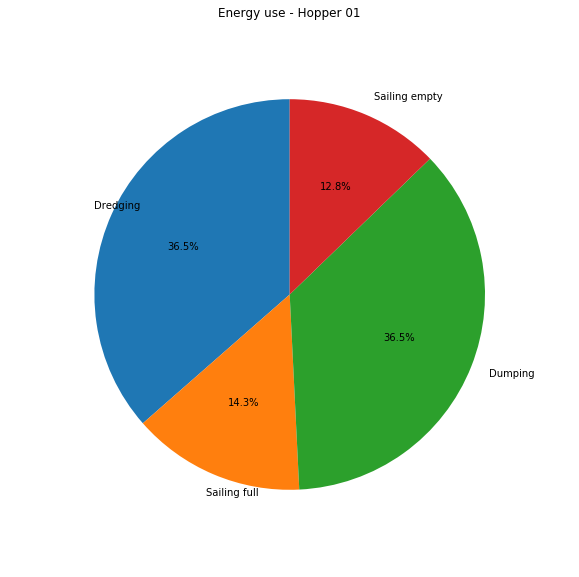

In [9]:
plot.energy_use(hopper)